In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

# %matplotlib notebook
%matplotlib inline

In [2]:
def barabasi_albert(n=10, m=4):
    G = nx.barabasi_albert_graph(n, m)
    G.graph["dissemination"] = "flooding"
    # compute power
    solving_rate = np.random.exponential(n, n).astype("d")
    for i in range(n):
        G.nodes[i]["compute"] = solving_rate[i] / np.sum(solving_rate)
    # edge distances
    n_edges = len(G.edges)
    distance = np.random.uniform(low=1, high=3, size=n_edges)
    for (a, b) in G.edges:
        G.edges[a, b]["distance"] = distance[i]
        G.edges[a, b]["delay"] = f"uniform {distance[i] * 0.5} {distance[i] * 1.5}"
        G.edges[a, b]["spring_weight"] = 1 / distance[i]
    distances = dict(nx.shortest_path_length(G, weight="distance"))
    # closeness / farness metrics
    node_attr = dict()
    for i, d in distances.items():
        farness = sum(d.values()) / (n - 1)
        compute_farness = sum([G.nodes[j]["compute"] * d for j, d in d.items()])
        node_attr[i] = dict(
            farness=farness,
            closeness=1 / farness,
            compute_farness=compute_farness,
            compute_closeness=1 / compute_farness,
        )
    nx.set_node_attributes(G, node_attr)
    # done
    return G


def sim(G, protocol="nakamoto", activation_delay=1, activations=1000):
    G = G.copy()
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    with subprocess.Popen(
        ["dune", "exec", "ocaml/bin/igraph_runner.exe"],
        cwd="../..",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        return nx.parse_graphml(out)


def draw(G, size="compute", layout=None):
    G = G.copy()
    size = nx.get_node_attributes(G, size).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

In [3]:
G = barabasi_albert(n=7)
pd.DataFrame.from_dict(G.nodes, orient="index")

,compute,farness,closeness,compute_farness,compute_closeness
0,0.039079,2.655360,0.376597,2.551592,0.391912
1,0.145693,4.868159,0.205416,4.433215,0.225570
2,0.165614,3.983040,0.251065,3.100711,0.322507
3,0.016916,3.983040,0.251065,3.890407,0.257043
4,0.170723,4.425600,0.225958,3.981204,0.251180
5,0.120166,3.097920,0.322797,2.723142,0.367223
6,0.341808,3.540480,0.282448,2.587935,0.386408


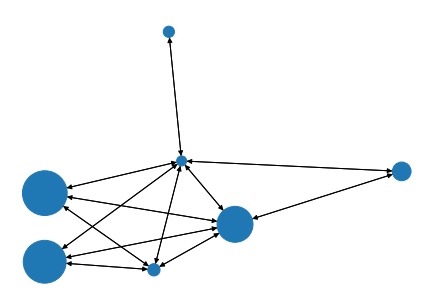

In [4]:
G = sim(barabasi_albert(n=7), activation_delay=1, activations=10000)
layout = draw(G)

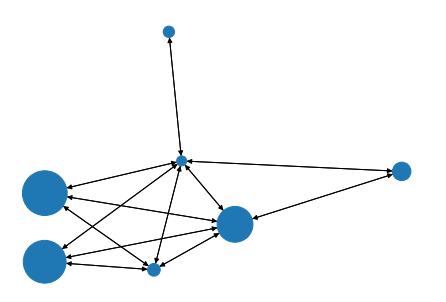

In [5]:
draw(G, size="activations", layout=layout)

In [6]:
runs = []
for _ in range(10):
    net = barabasi_albert(n=7)
    cf = dict(G.nodes(data="compute_farness")).values()
    est_progagation_delay = sum(cf) / len(cf)
    for p in ["nakamoto", "ethereum", "tailstorm 8 constant", "tailstorm 8 discount"]:
        G = sim(
            net,
            activation_delay=2 * est_progagation_delay,
            activations=1000,
            protocol=p,
        )
        d = pd.DataFrame.from_dict(G.nodes, orient="index")
        d["protocol"] = p
        runs.append(d)
df = pd.concat(runs)
# calculate metrics
df["relative_reward"] = df.reward / np.sum(df.reward)
df["relative_activations"] = df.reward / np.sum(df.activations)
df["efficiency"] = df.reward / G.graph["head_progress"] / df.compute
df.efficiency.fillna(0, inplace=True)
display(df)

,activations,reward,compute_closeness,compute_farness,closeness,farness,compute,protocol,relative_reward,relative_activations,efficiency
n0,219.0,195.000,1.108068,0.902472,0.883110,1.132362,0.203018,nakamoto,0.005879,0.004875,1.035026
n1,205.0,165.000,0.750253,1.332883,0.529866,1.887270,0.195126,nakamoto,0.004974,0.004125,0.911214
n2,81.0,63.000,0.574964,1.739239,0.529866,1.887270,0.095929,nakamoto,0.001899,0.001575,0.707686
n3,95.0,70.000,0.678903,1.472965,0.588740,1.698543,0.098680,nakamoto,0.002110,0.001750,0.764398
n4,120.0,98.000,0.653910,1.529262,0.529866,1.887270,0.108414,nakamoto,0.002955,0.002450,0.974074
...,...,...,...,...,...,...,...,...,...,...,...
n2,148.0,112.875,0.381865,2.618729,0.302227,3.308772,0.135763,tailstorm 8 discount,0.003403,0.002822,0.895918
n3,242.0,190.625,0.460374,2.172147,0.335808,2.977895,0.247592,tailstorm 8 discount,0.005747,0.004766,0.829652
n4,199.0,154.250,0.425292,2.351327,0.335808,2.977895,0.202464,tailstorm 8 discount,0.004650,0.003856,0.820974
n5,292.0,234.125,0.703092,1.422290,0.377784,2.647018,0.288368,tailstorm 8 discount,0.007058,0.005853,0.874890


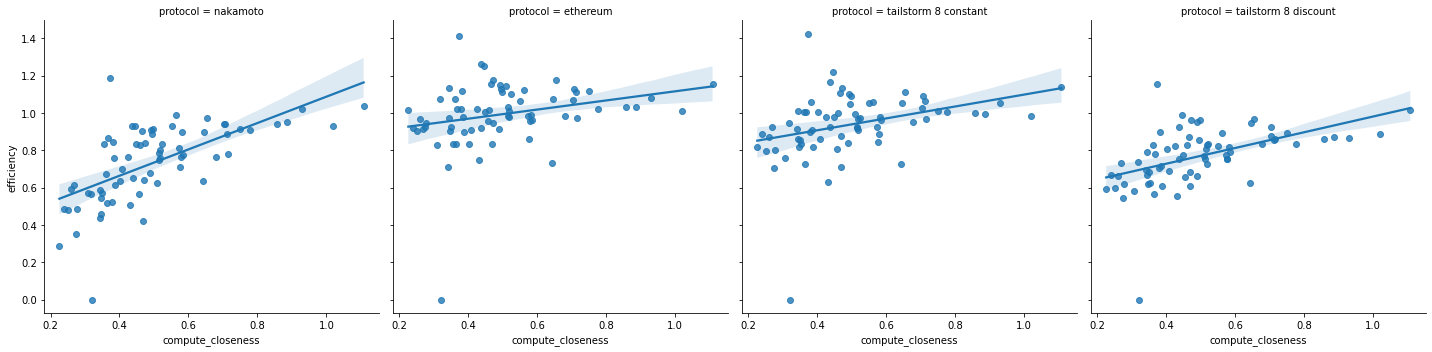

In [7]:
sns.lmplot(data=df, x="compute_closeness", y="efficiency", col="protocol")

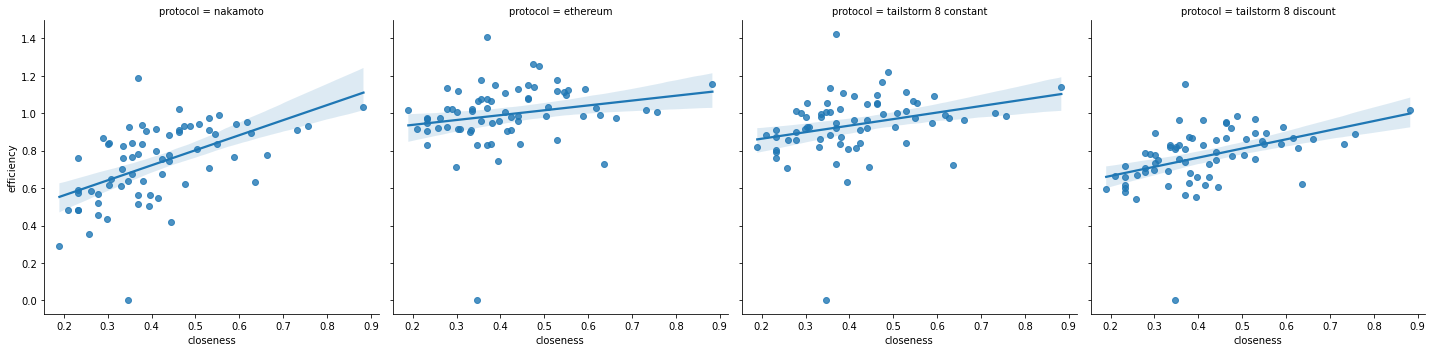

In [8]:
sns.lmplot(data=df, x="closeness", y="efficiency", col="protocol")